In [1]:
import typing as t

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use({'figure.facecolor':'white'})

In [2]:
class Bandit:
    def __init__(self, success_probability: float):
        self._p = success_probability

    def pull(self, rand_num_generator=None, seed=None) -> bool:
        """
        "query" the bandit to see if we succeeded or not, based on the
        `success_probability` given at init

        Args:
            rand_num_generator: random number generator instance to use.
                If None, create own via np.random.default_rng()
            seed: If specified, will create a new random number generator
                using this seed. np.random.default_rng(seed)

        Returns:
            bool: True if we succeeded, False if not
        """
        return self._pull_uniform(rand_num_generator, seed)

    def _pull_uniform(self,
                      rand_num_generator: np.random.Generator=None,
                      seed:int=None) -> bool:
        rng = self._initialize_random_number_generator_if_needed(rand_num_generator,seed)
        return (rng.random() < self._p)

    @staticmethod
    def _initialize_random_number_generator_if_needed(
            random_number_generator: np.random.Generator=None,
            seed: int=None) -> np.random.Generator:
        if (random_number_generator is None) or (seed is not None):
            return np.random.default_rng(seed)

        return random_number_generator

In [3]:
def create_bandits(success_probabilities: t.List[float]) -> t.List[Bandit]:
    """
    Given a list of success probabilities, create a list of bandits with
    those success probabilities
    """

    return [Bandit(p) for p in success_probabilities]

In [4]:
class PlayEpsilonGreedy:
    def __init__(self, bandits: t.List[Bandit], epsilon: float):
        self.bandits = bandits
        self._n_bandits = len(bandits)
        self._best_bandits = self._find_best_bandits()

        self.epsilon = epsilon


    def _find_best_bandits(self) -> t.Set[int]:
        """
        For report building purposes, find the actual set of best bandits

        Returns:
            set: set of indicies in self.bandits of the best bandits
        """

        best_success_probability = 0.
        best_bandit_indices = set()

        for idx, bandit in enumerate(self.bandits):
            if bandit._p > best_success_probability:
                best_success_probability = bandit._p
                best_bandit_indices = {idx}
            elif bandit._p == best_success_probability:
                best_bandit_indices.add(idx)

        return best_bandit_indices

    bandit_scores_t = np.ndarray
    bandit_draws_t = np.ndarray
    earnings_per_round_t = np.ndarray
    best_bandit_chosen_t = np.ndarray

    def play(self,
             times: int,
             rand_num_generator: np.random.Generator=None,
             seed: int=None) -> t.Tuple[bandit_scores_t,
                                        bandit_draws_t,
                                        earnings_per_round_t,
                                        best_bandit_chosen_t]:
        rng = self._initialize_random_number_generator_if_needed(
            random_number_generator=rand_num_generator,
            seed=seed
        )
        bandit_scores = np.zeros(self._n_bandits)
        bandit_draws = np.zeros(self._n_bandits)  # number of times a given bandit was chosen
        earnings_per_round = np.zeros(times)
        best_bandit_chosen = np.zeros(times)

        for i in range(times):
            should_play_random = (rng.random() < self.epsilon)

            if should_play_random:
                bandit_chosen = rng.integers(self._n_bandits)
                self._play_bandit_and_update_score(
                    bandit_chosen,
                    rng,
                    bandit_draws,
                    bandit_scores,
                    earnings_per_round,
                    best_bandit_chosen,
                    i
                )

            else:
                current_best_score = np.amax(bandit_scores)
                bandits_with_best_score = np.argwhere(bandit_scores == current_best_score)
                bandit_chosen = rng.choice(bandits_with_best_score)[0]

                self._play_bandit_and_update_score(
                    bandit_chosen,
                    rng,
                    bandit_draws,
                    bandit_scores,
                    earnings_per_round,
                    best_bandit_chosen,
                    i
                )
        return bandit_scores, bandit_draws, earnings_per_round, best_bandit_chosen


    @staticmethod
    def _initialize_random_number_generator_if_needed(
            random_number_generator: np.random.Generator=None,
            seed: int=None) -> np.random.Generator:
        if (random_number_generator is None) or (seed is not None):
            return np.random.default_rng(seed)

        return random_number_generator


    def _play_bandit_and_update_score(
            self,
            bandit_chosen: int,
            rng: np.random.Generator,
            bandit_draws: t.List,
            bandit_scores: t.List,
            bandit_earnings: t.List,
            best_bandit_chosen: t.List,
            iteration: int) -> None:

        reward = self.bandits[bandit_chosen].pull(rand_num_generator=rng)
        bandit_draws[bandit_chosen] += 1
        bandit_scores[bandit_chosen] = (
                bandit_scores[bandit_chosen] +
                (reward - bandit_scores[bandit_chosen]) / bandit_draws[bandit_chosen]
        )
        bandit_earnings[iteration] = reward
        best_bandit_chosen[iteration] = (bandit_chosen in self._best_bandits)

    best_chosen_record_t = np.ndarray
    earnings_record_t = np.ndarray

    def play_many(self,
                  total_runs: int,
                  iterations_per_run: int,
                  seed: int=None) -> t.Tuple[best_chosen_record_t, earnings_record_t]:
        rng = self._initialize_random_number_generator_if_needed(seed=seed)
        best_chosen_record = []
        earnings_record = []

        for _ in range(total_runs):
            scores, chosen_cnt, earnings, best_chosen = self.play(
                times=iterations_per_run,
                rand_num_generator=rng
            )
            best_chosen_record.append(best_chosen)
            earnings_record.append(earnings)


        best_chosen_record = np.stack(best_chosen_record)
        earnings_record = np.stack(earnings_record)

        return best_chosen_record, earnings_record



In [5]:
rounds = 1_000
iterations_per_round = 500
epsilons = [1.0, 0.75, 0.5, 0.25, 0.1, 0.01]
labels = [str(x) for x in epsilons]
best, total_score = dict(), dict()
for epsilon, label in zip(epsilons, labels):
    best[label], total_score[label] = PlayEpsilonGreedy(
        create_bandits([0.4, 0.05]), epsilon=epsilon
    )\
        .play_many(rounds, iterations_per_round)

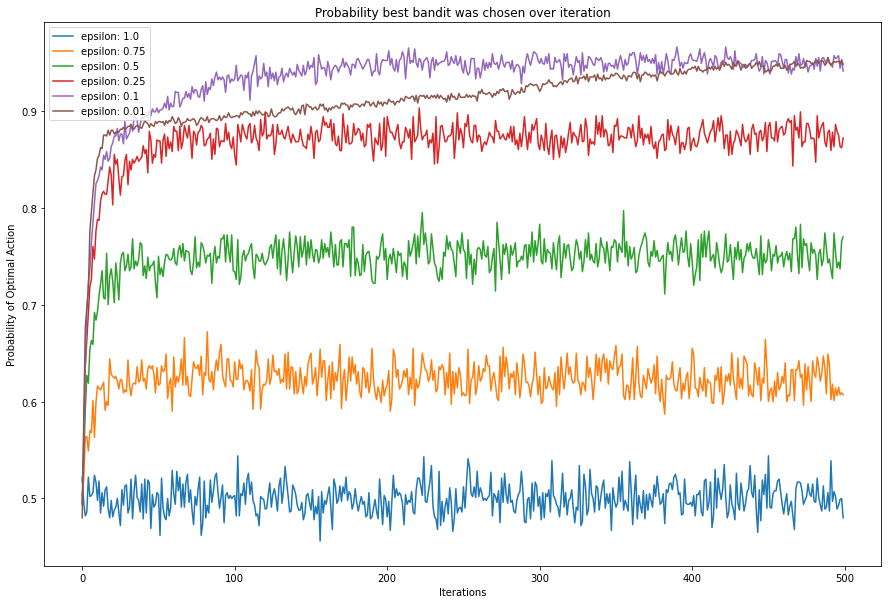

In [6]:
plt.figure(figsize=(15,10))
for label, data in best.items():
    plt.plot(np.mean(data, axis=0), label=f'epsilon: {label}')

plt.title('Probability best bandit was chosen over iteration')
plt.xlabel('Iterations')
plt.ylabel('Probability of Optimal Action')
plt.legend()
plt.show()

Asymptotic value is

$$
\frac{\epsilon}{n} + (1-\epsilon) = \frac{\epsilon (1 - n) + n}{n}
$$

where n = the number of competing bandits, and $\epsilon$ is the proportion of
time spent exploring (as usual).  As $\epsilon \rightarrow 0$ (no exploration),
we have the algorithm always pick the optimal outcome, while as $\epsilon \rightarrow 1$
(always exploring), we have the optimum bandit only chosen randomly.

This is what we observe above (where $\epsilon = 0.01$ hasn't reached is
asymptotic behavior yet).

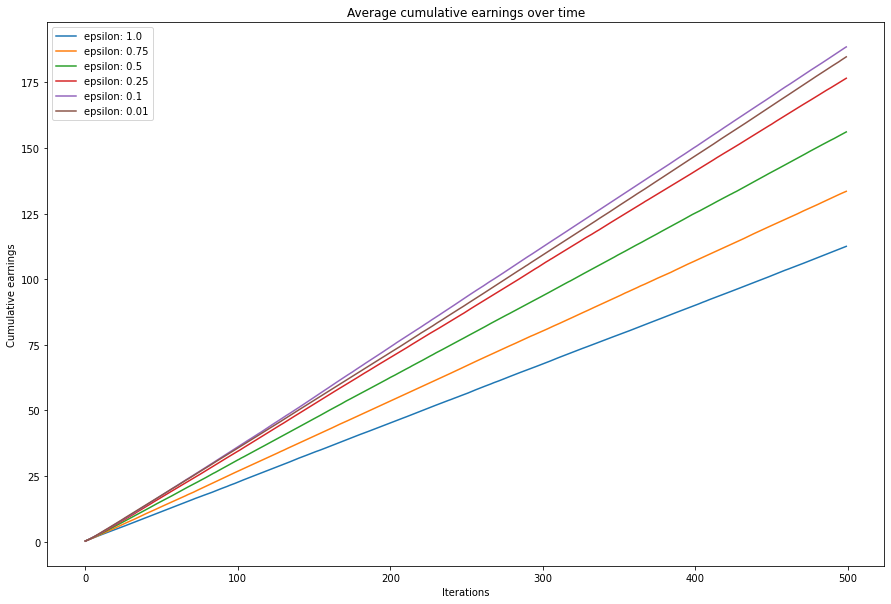

In [7]:
plt.figure(figsize=(15,10))
for label, data in total_score.items():
    plt.plot(np.mean(np.cumsum(data, axis=1), axis=0), label=f'epsilon: {label}')

plt.title('Average cumulative earnings over time')
plt.xlabel('Iterations')
plt.ylabel('Cumulative earnings')
plt.legend()
plt.show()

More or less as expected, the lower the exploration ($\epsilon$)/ higher
the exploitation ($1 - \epsilon$), the higher the cumulative earnings.  However,
because $\epsilon = 0.01$ hasn't approached it's asymptotic behavior yet, we see
that it's cumulative earnings is actually below the $\epsilon = 0.1$ case.  This
should eventually overtake the $\epsilon = 0.1$ case, but not for a while.